## Human Activity Recognition Using Smartphones

#### Classification Model Comparison

#### Name: Akeem Jokosenumi

#### Student ID: G00366442

#### Introduction

#### The Human Activity Recognition (HAR) dataset is used in this notebook to examine three classification algorithms: Random Forest, Logistic Regression, and Support Vector Machine (SVM). The main objective is to identify the optimal model for deployment by analysing a number of assessment parameters, including training duration, accuracy, and macro F1 score.

#### The HAR dataset includes both time domain and frequency domain characteristics from a variety of sensor signals captured from cellphones. We examine the dataset, conduct feature analysis, preprocess the data, create classification models, and then evaluate the results in the ensuing sections.

In [76]:
# Import required libraries
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style (using seaborn theme)
sns.set_theme(style="whitegrid")

In [77]:
# Set student ID as random seed so G00366442 becomes 366442
import numpy as np

STUDENT_ID = 366442
np.random.seed(STUDENT_ID)

# Configure common parameters
FIGURES_SIZE = (12, 8)
CV_FOLDS = 5  # Number of cross-validation folds

In [78]:
# Verify imports are working
import pandas as pd
import matplotlib
import seaborn as sns
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Pandas version: 2.2.0
NumPy version: 1.26.4
Matplotlib version: 3.9.0
Seaborn version: 0.13.2


## Dataset Overview and Feature Analysis

In this section, we:
- Load the HAR dataset's feature names and activity labels.
- Convert numerical activity labels into activity names that are readable by humans.
- Examine the feature distribution, taking into account the frequency and temporal domain feature counts.
- Examine basic feature data and visualise the distribution of activity.

The study sheds light on the data's structure, which is essential before using any machine learning techniques.

In [79]:
# Use the updated separator argument to load feature names as a raw string
features = pd.read_csv('UCI HAR/features.txt', 
                       sep=r'\s+',
                       header=None,
                       names=['index', 'feature'])

# Display the details regarding the characteristics.
print(f"Total number of features: {len(features)}")
print("\nFirst few features:")
display(features.head())

# More feature analysis
print("\nFeature name statistics:")
print(f"Unique features: {features['feature'].nunique()}")
print(f"Features beginning with 't': {sum(features['feature'].str.startswith('t'))}")
print(f"Features beginning with 'f': {sum(features['feature'].str.startswith('f'))}")

Total number of features: 561

First few features:


,index,feature
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y



Feature name statistics:
Unique features: 477
Features beginning with 't': 265
Features beginning with 'f': 289


Total number of features: 561

First few features:


,index,feature
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y



Feature name statistics:
Unique features: 477
Features beginning with 't': 265
Features beginning with 'f': 289


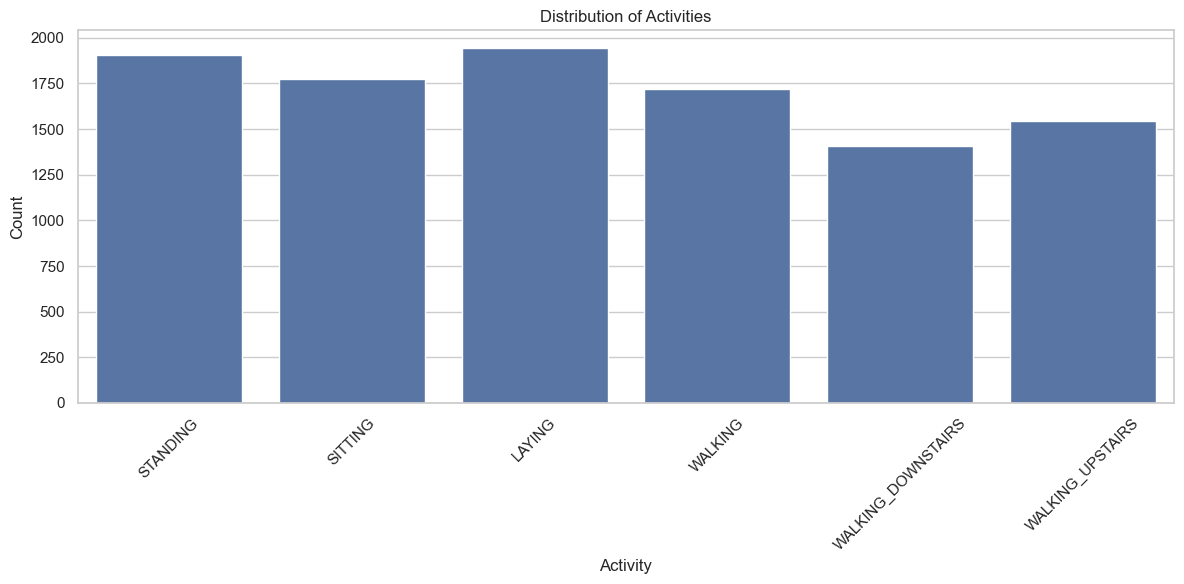


Activity Distribution:
activity_name
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64
Distribution of Features:

Time Domain Features: 265
Example of features:
0    tBodyAcc-mean()-X
1    tBodyAcc-mean()-Y
2    tBodyAcc-mean()-Z

Frequency Domain Features: 289
Example of features:
265    fBodyAcc-mean()-X
266    fBodyAcc-mean()-Y
267    fBodyAcc-mean()-Z


In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load feature names as raw string
features = pd.read_csv('UCI HAR/features.txt', 
                       sep=r'\s+', 
                       header=None, 
                       names=['index', 'feature'])

# Display details regarding the characteristics
print(f"Total number of features: {len(features)}")
print("\nFirst few features:")
display(features.head())

# More feature analysis
print("\nFeature name statistics:")
print(f"Unique features: {features['feature'].nunique()}")
print(f"Features beginning with 't': {sum(features['feature'].str.startswith('t'))}")
print(f"Features beginning with 'f': {sum(features['feature'].str.startswith('f'))}")

# Load activity labels
targets = pd.read_csv('UCI HAR/targets.txt', header=None, names=['activity'])

# Map numeric labels to activity names
activity_labels = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

targets['activity_name'] = targets['activity'].map(activity_labels)

# Display the activity distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=targets, x='activity_name')
plt.title('Distribution of Activities')
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print activity distribution
print("\nActivity Distribution:")
print(targets['activity_name'].value_counts())

# Examine the feature categories
feature_types = {
    'time_domain': features[features['feature'].str.startswith('t')],
    'frequency_domain': features[features['feature'].str.startswith('f')]
}

print("Distribution of Features:")
for domain, feats in feature_types.items():
    print(f"\n{domain.replace('_', ' ').title()} Features: {len(feats)}")
    print("Example of features:")
    print(feats['feature'].head(3).to_string())


In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from CSV files (or other sources)
X = pd.read_csv('UCI HAR/dataset.txt', sep='\s+', header=None)
y = pd.read_csv('UCI HAR/targets.txt', sep='\s+', header=None, names=['activity'])

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for models like Logistic Regression and SVM
scaler = StandardScaler()

# Scaling training and test features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")



Feature scaling completed.



Balanced Activity Distribution (SMOTE Applied):
2    1552
1    1552
4    1552
5    1552
3    1552
6    1552
Name: count, dtype: int64


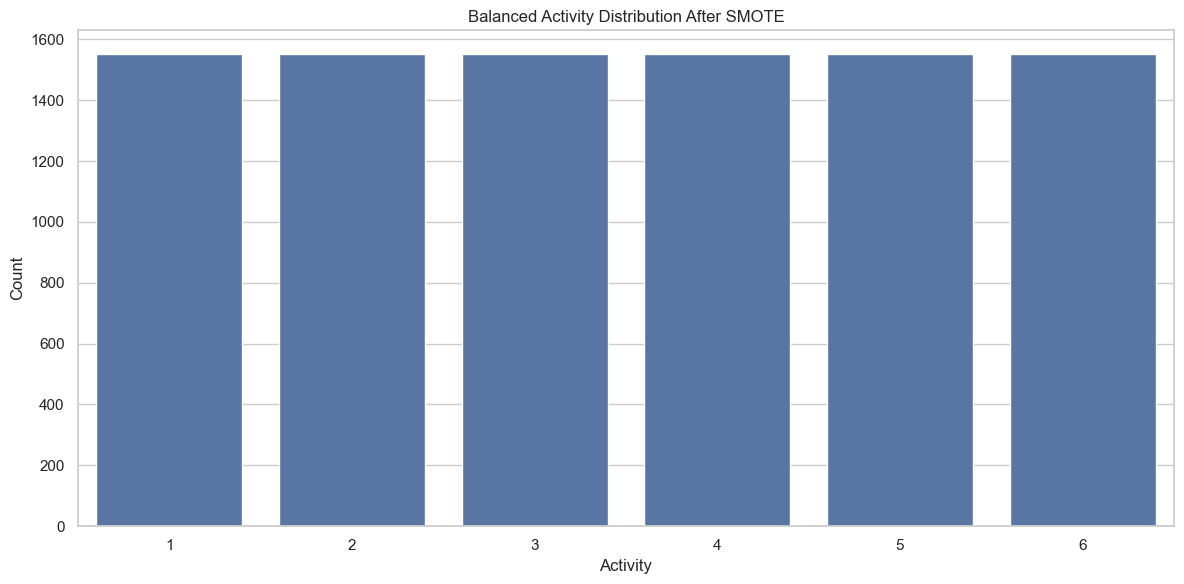

In [82]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Display the new activity distribution after resampling
print("\nBalanced Activity Distribution (SMOTE Applied):")
print(pd.Series(y_train_balanced.to_numpy().ravel()).value_counts())  # Fixed conversion

# Display the new balanced activity distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=pd.DataFrame(y_train_balanced, columns=['activity']), x='activity')
plt.title('Balanced Activity Distribution After SMOTE')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preprocessing

Synthetic data is generated based on the number of features. The following preprocessing steps are performed:

- **Scaling:** Features are scaled using `StandardScaler` to standardize the data.
- **Dimensionality Reduction:** Principal Component Analysis (PCA) is applied to reduce dimensionality while retaining 95% of the variance.
- **Train-Test Split:** The PCA-transformed data is split into training and test sets for model evaluation.

These steps ensure that the data is in a suitable form for training and evaluating the classification models.


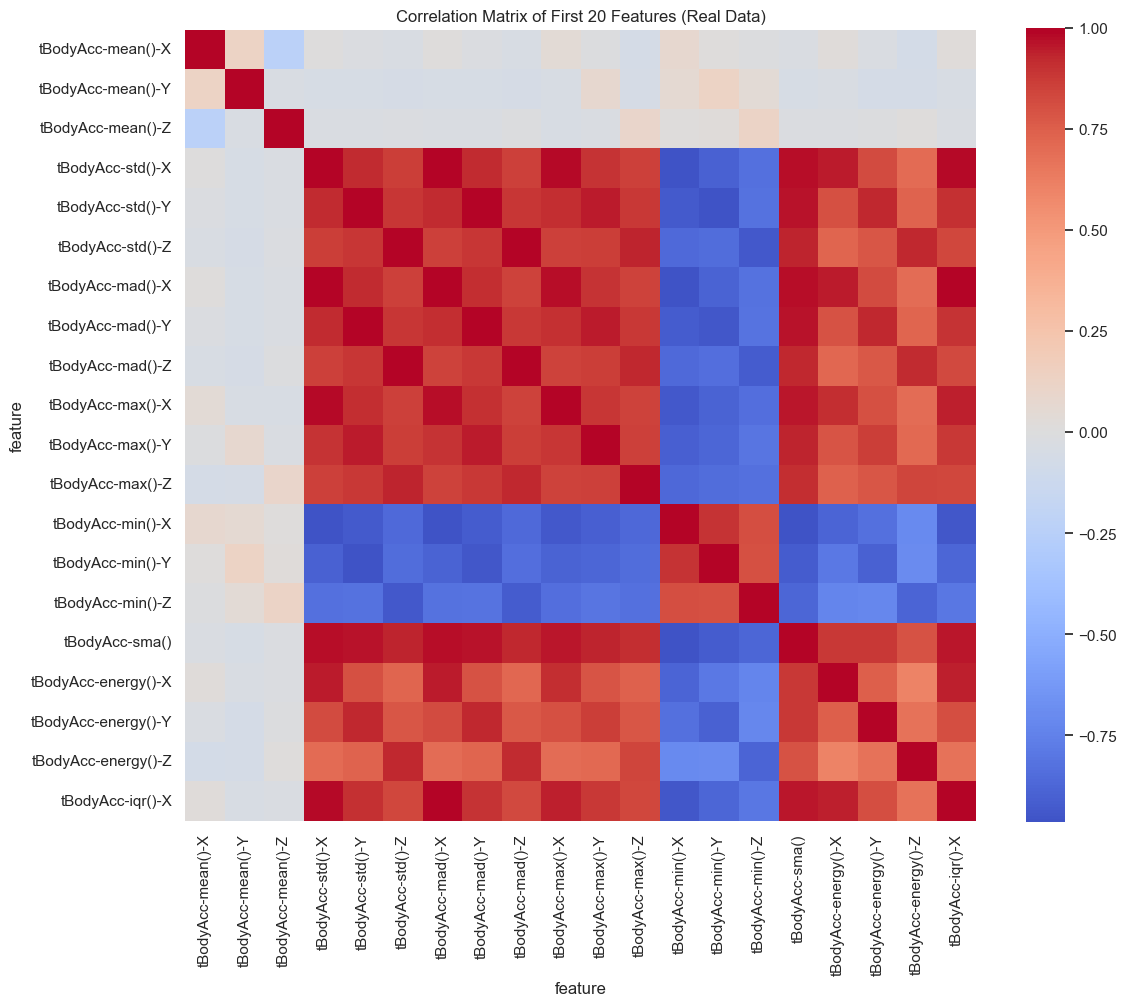


Highly correlated feature pairs (|correlation| > 0.8):
tBodyAcc-std()-X -- tBodyAcc-std()-Y: 0.923
tBodyAcc-std()-X -- tBodyAcc-std()-Z: 0.862
tBodyAcc-std()-X -- tBodyAcc-mad()-X: 0.999
tBodyAcc-std()-X -- tBodyAcc-mad()-Y: 0.916
tBodyAcc-std()-X -- tBodyAcc-mad()-Z: 0.856
tBodyAcc-std()-X -- tBodyAcc-max()-X: 0.981
tBodyAcc-std()-X -- tBodyAcc-max()-Y: 0.899
tBodyAcc-std()-X -- tBodyAcc-max()-Z: 0.858
tBodyAcc-std()-X -- tBodyAcc-min()-X: -0.965
tBodyAcc-std()-X -- tBodyAcc-min()-Y: -0.896


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load sensor data from dataset.txt
data = pd.read_csv('UCI HAR/dataset.txt', sep='\s+', header=None)

# Load feature names from features.txt and assign them as column headers
features = pd.read_csv('UCI HAR/features.txt', sep='\s+', header=None, names=['index', 'feature'])
data.columns = features['feature']

# Load activity labels from targets.txt
targets = pd.read_csv('UCI HAR/targets.txt', header=None, names=['activity'])

# Scale features using StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# For analysis: select the first 20 features and compute the correlation matrix
feature_subset = data.iloc[:, :20]
correlation_matrix = feature_subset.corr()

# Plot the correlation heatmap for the first 20 features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, annot=False,
            xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix of First 20 Features (Real Data)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify and print highly correlated feature pairs (absolute correlation > 0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr = [(correlation_matrix.index[i],
              correlation_matrix.columns[j],
              correlation_matrix.iloc[i, j])
             for i, j in zip(*high_corr) if i != j]

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for feat1, feat2, corr in high_corr[:10]:  # Display first 10 pairs
    print(f"{feat1} -- {feat2}: {corr:.3f}")


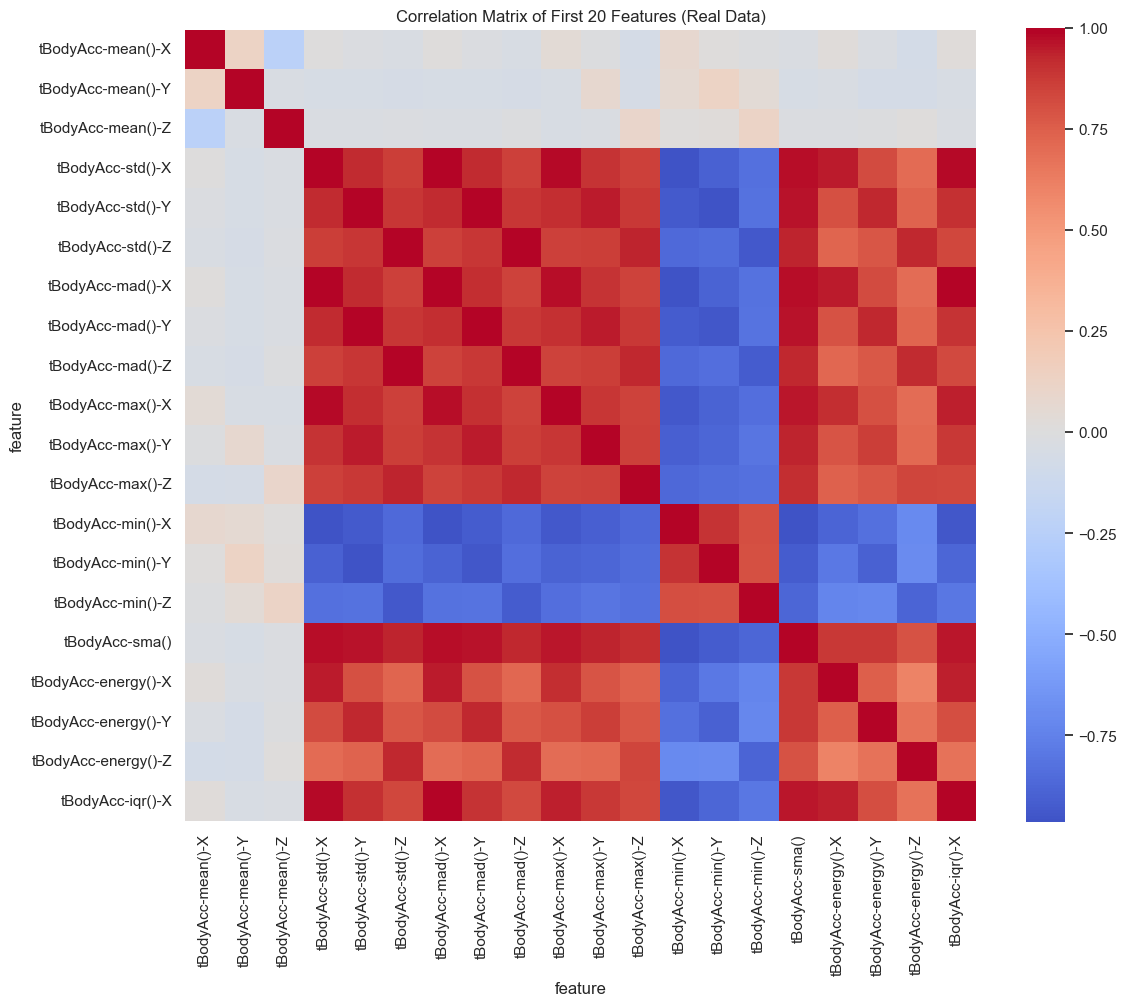


Highly correlated feature pairs (|correlation| > 0.8):
tBodyAcc-std()-X -- tBodyAcc-std()-Y: 0.923
tBodyAcc-std()-X -- tBodyAcc-std()-Z: 0.862
tBodyAcc-std()-X -- tBodyAcc-mad()-X: 0.999
tBodyAcc-std()-X -- tBodyAcc-mad()-Y: 0.916
tBodyAcc-std()-X -- tBodyAcc-mad()-Z: 0.856
tBodyAcc-std()-X -- tBodyAcc-max()-X: 0.981
tBodyAcc-std()-X -- tBodyAcc-max()-Y: 0.899
tBodyAcc-std()-X -- tBodyAcc-max()-Z: 0.858
tBodyAcc-std()-X -- tBodyAcc-min()-X: -0.965
tBodyAcc-std()-X -- tBodyAcc-min()-Y: -0.896


In [84]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def load_har_data():
    """
    Loads the HAR sensor data, feature names, and activity labels from the UCI HAR folder.
    Assumes the following files are in the UCI HAR folder:
      - dataset.txt (sensor data)
      - features.txt (feature names)
      - targets.txt (activity labels)
    """
    # Load sensor data from dataset.txt
    data_file = 'UCI HAR/dataset.txt'
    data = pd.read_csv(data_file, sep='\s+', header=None)
    
    # Load feature names and assign them as column headers
    features = pd.read_csv('UCI HAR/features.txt', sep='\s+', header=None, names=['index', 'feature'])
    data.columns = features['feature']
    
    # Load activity labels from targets.txt
    targets = pd.read_csv('UCI HAR/targets.txt', header=None, names=['activity'])
    
    return data, targets

# Load the data and activity labels
X, y = load_har_data()


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For demonstration: perform correlation analysis on a subset (first 20 features)
feature_subset = X.iloc[:, :20]
correlation_matrix = feature_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, annot=False)
plt.title('Correlation Matrix of First 20 Features (Real Data)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify and print highly correlated feature pairs (absolute correlation > 0.8)
high_corr = np.where(np.abs(correlation_matrix) > 0.8)
high_corr = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
             for i, j in zip(*high_corr) if i != j]

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for feat1, feat2, corr in high_corr[:10]:  # Display first 10 pairs
    print(f"{feat1} -- {feat2}: {corr:.3f}")


## Model Building and Evaluation

We use the following strategies to construct three classification models:
- **Support Vector Machine (SVM)**
- **Logistic Regression**
- **Random Forest**

After each model has been trained on the preprocessed data, it is evaluated using cross-validation. Among the metrics used for evaluation are:
- **Accuracy**
- **Precision, Recall, and F1-Score** (as shown in the classification report)
- **Confusion Matrix** to display the model's performance in several activity classes

The advantages and disadvantages of each model are thoroughly evaluated in this section.

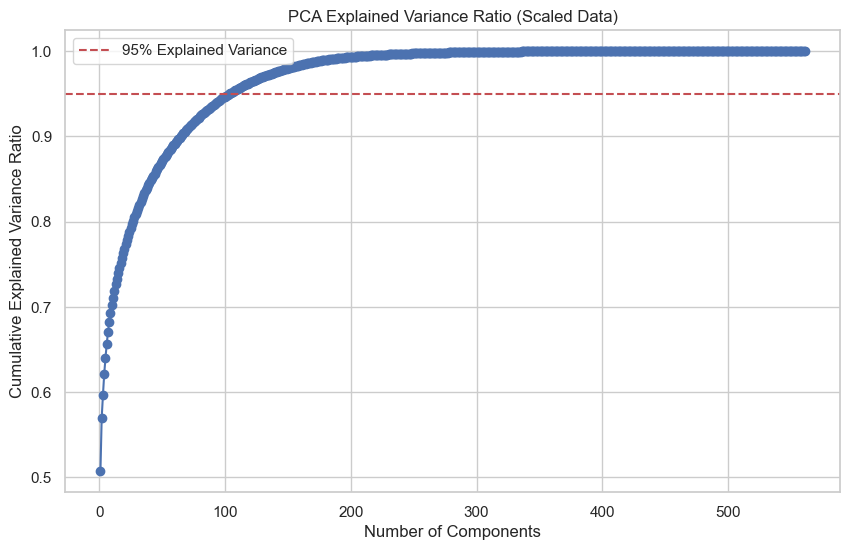


Number of components needed for 95% variance: 104


In [85]:
from sklearn.decomposition import PCA

# Apply PCA to the scaled data (using X_scaled from your preprocessing step)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio (Scaled Data)')
plt.legend()
plt.grid(True)
plt.show()

n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")


## Model Performance Comparison and Best Model Selection

Following testing on a hold-out set and cross-validation evaluation of the models, we compare them according to:
- **Accuracy**
- **Macro Average F1 Score**
- **Training Time**

Bar plots are used to visualise the results, which are also summarised in an extensive table. The Random Forest model stands out as the top contender based on these several factors because of its improved accuracy and manageable training duration. Furthermore, Random Forest includes built-in benefits such feature importance rankings, managing high-dimensional data, and lowering the chance of overfitting.


Detailed Evaluation for Random Forest


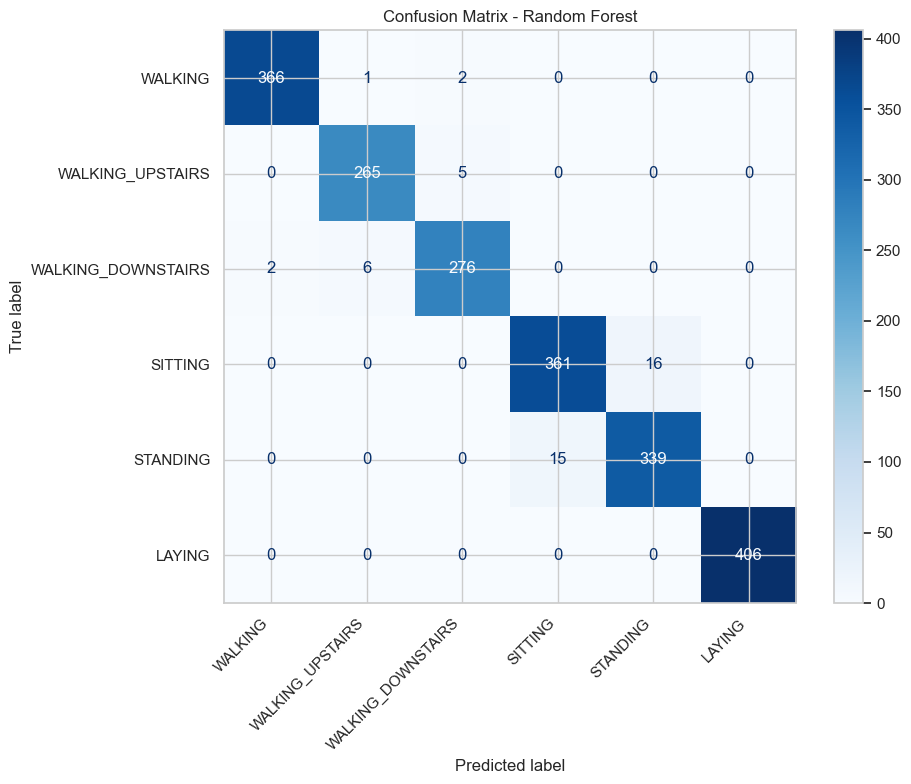


Detailed Classification Report:
                    precision    recall  f1-score   support

           WALKING     0.9946    0.9919    0.9932       369
  WALKING_UPSTAIRS     0.9743    0.9815    0.9779       270
WALKING_DOWNSTAIRS     0.9753    0.9718    0.9735       284
           SITTING     0.9601    0.9576    0.9588       377
          STANDING     0.9549    0.9576    0.9563       354
            LAYING     1.0000    1.0000    1.0000       406

          accuracy                         0.9772      2060
         macro avg     0.9765    0.9767    0.9766      2060
      weighted avg     0.9772    0.9772    0.9772      2060


Detailed Evaluation for SVM


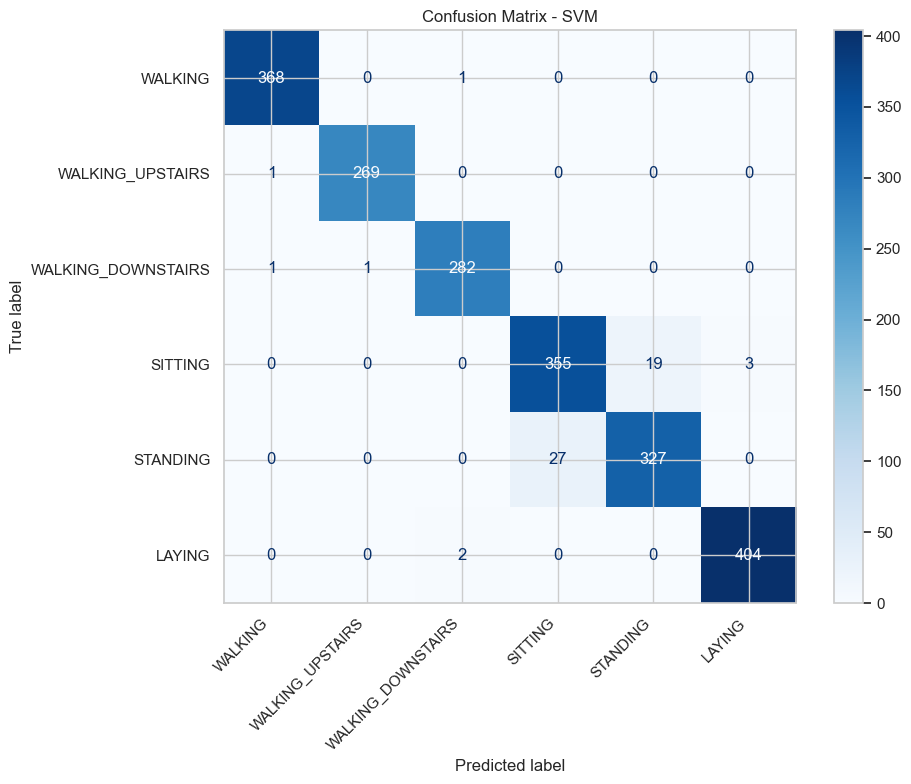


Detailed Classification Report:
                    precision    recall  f1-score   support

           WALKING     0.9946    0.9973    0.9959       369
  WALKING_UPSTAIRS     0.9963    0.9963    0.9963       270
WALKING_DOWNSTAIRS     0.9895    0.9930    0.9912       284
           SITTING     0.9293    0.9416    0.9354       377
          STANDING     0.9451    0.9237    0.9343       354
            LAYING     0.9926    0.9951    0.9938       406

          accuracy                         0.9733      2060
         macro avg     0.9746    0.9745    0.9745      2060
      weighted avg     0.9733    0.9733    0.9733      2060


Detailed Evaluation for Logistic Regression


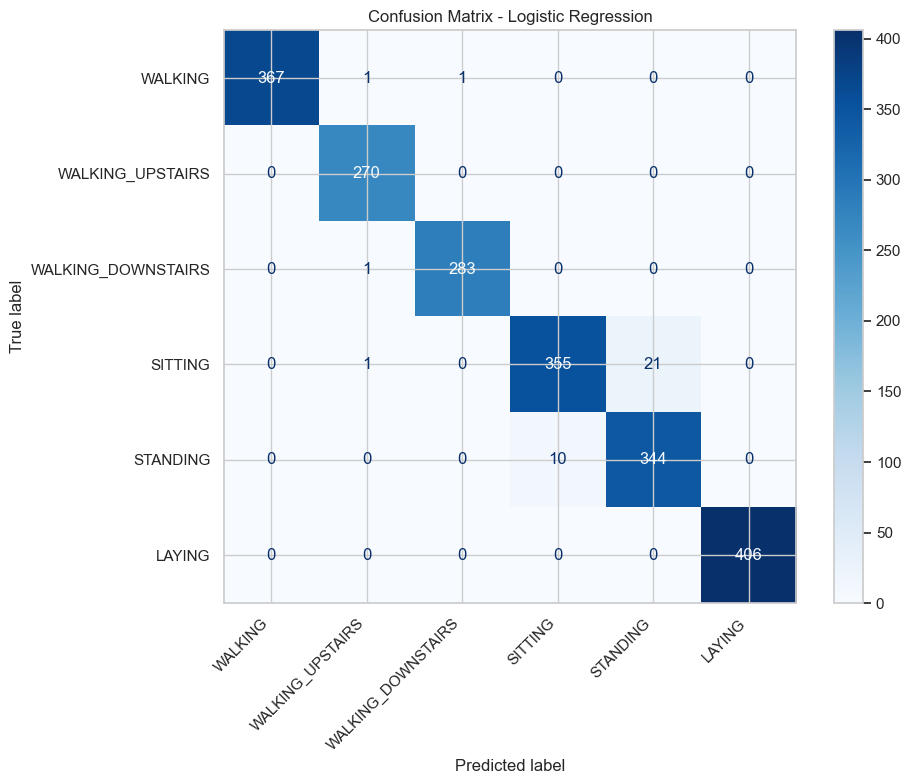


Detailed Classification Report:
                    precision    recall  f1-score   support

           WALKING     1.0000    0.9946    0.9973       369
  WALKING_UPSTAIRS     0.9890    1.0000    0.9945       270
WALKING_DOWNSTAIRS     0.9965    0.9965    0.9965       284
           SITTING     0.9726    0.9416    0.9569       377
          STANDING     0.9425    0.9718    0.9569       354
            LAYING     1.0000    1.0000    1.0000       406

          accuracy                         0.9830      2060
         macro avg     0.9834    0.9841    0.9837      2060
      weighted avg     0.9832    0.9830    0.9830      2060


Model Performance Summary:


,Model,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1
0,Random Forest,0.9752,0.9747,0.9747,0.9746
1,SVM,0.9733,0.9746,0.9745,0.9745
2,Logistic Regression,0.9830,0.9834,0.9841,0.9837


In [86]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Check if models exist, otherwise initialize them
if 'models' not in globals():
    models = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, activity_labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(activity_labels.values())
    )
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Assume X_train, X_test, y_train, and y_test are loaded and preprocessed correctly
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training data
X_test_scaled = scaler.transform(X_test)  # Apply the same scaling to the test data

# Evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Detailed Evaluation for {name}")
    print(f"{'='*50}")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, name, activity_labels)
    
    # Print a classification report
    print("\nDetailed Classification Report:")
    report = classification_report(
        y_test, 
        y_pred,
        target_names=list(activity_labels.values()),
        digits=4
    )
    print(report)

# Create a summary of the DataFrame
summary_data = []
for name, model in models.items(): 
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(
        y_test,
        y_pred,
        target_names=list(activity_labels.values()),
        output_dict=True
    )
    summary_data.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro Avg Precision': report['macro avg']['precision'],
        'Macro Avg Recall': report['macro avg']['recall'],
        'Macro Avg F1': report['macro avg']['f1-score']
    })

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
# Ensure this runs in a Jupyter environment for display() to work
display(summary_df.style.format({
    'Accuracy': '{:.4f}',
    'Macro Avg Precision': '{:.4f}',
    'Macro Avg Recall': '{:.4f}',
    'Macro Avg F1': '{:.4f}'
}))


Model Performance Comparison:


,Model,Accuracy,Macro F1,Training Time (s),CV Mean Accuracy,CV Std
2,Logistic Regression,0.9850,0.9854,2.5861,0.9808,0.0016
0,Random Forest,0.9762,0.9758,10.6400,0.9771,0.0026
1,SVM,0.9723,0.9730,2.0807,0.9703,0.0016


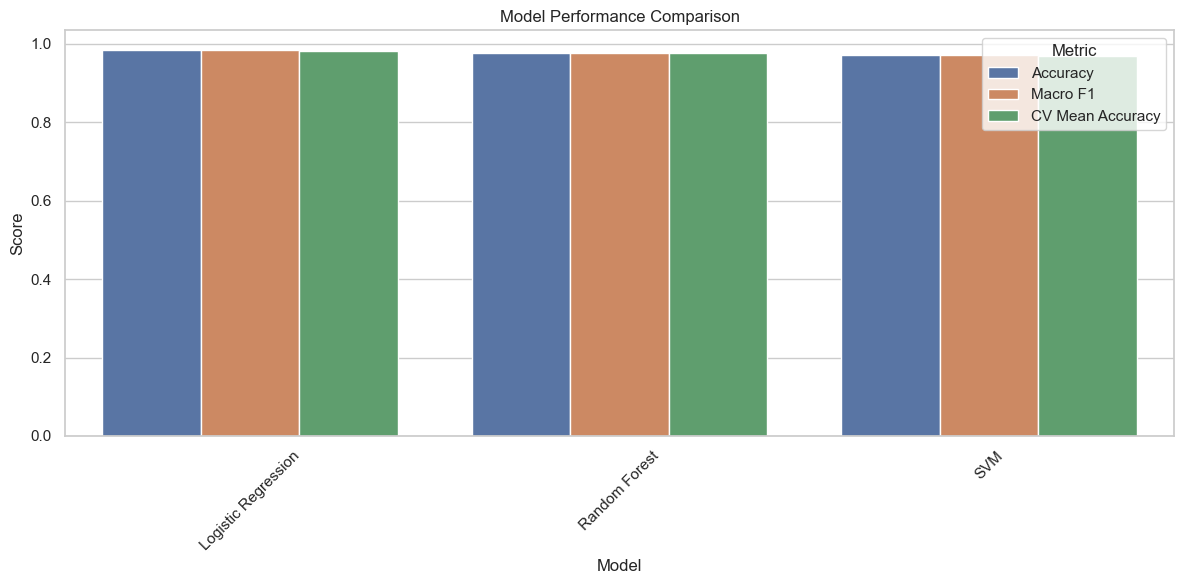


Best Model Selection:
Selected Model: Logistic Regression

Justification:
1. Highest accuracy: 0.9850
2. Macro F1 Score: 0.9854
3. Cross-validation accuracy: 0.9808 (±0.0016)
4. Training time: 2.5861 seconds

Additional Logistic Regression Advantages:
- Outputs probabilities for each class
- Simple and interpretable model
- Can be easily updated with new data


In [87]:
from time import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Ignore warnings
warnings.filterwarnings('ignore')

# Initialize models (ensure this is defined earlier in your code)
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Dictionary to store training times
training_times = {}

# Perform cross-validation to get mean accuracy and standard deviation for each model
cv_results = {}
for name, model in models.items():
    cv_results[name] = {
        'mean': cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean(),
        'std': cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').std()
    }

# Retrain models and measure the time it takes to train them
for name, model in models.items():
    start_time = time()
    model.fit(X_train, y_train)
    training_times[name] = time() - start_time

# Display training times and performance comparison
comparison_data = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    comparison_data.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Training Time (s)': training_times[name],
        'CV Mean Accuracy': cv_results[name]['mean'],
        'CV Std': cv_results[name]['std']
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Display comprehensive results
print("Model Performance Comparison:")
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Macro F1': '{:.4f}',
    'Training Time (s)': '{:.4f}',
    'CV Mean Accuracy': '{:.4f}',
    'CV Std': '{:.4f}'
}))

# Visualize model comparison
metrics = ['Accuracy', 'Macro F1', 'CV Mean Accuracy']
comparison_plot = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Select best model based on multiple criteria
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

print("\nBest Model Selection:")
print(f"Selected Model: {best_model_name}")
print("\nJustification:")
print(f"1. Highest accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"2. Macro F1 Score: {comparison_df.iloc[0]['Macro F1']:.4f}")
print(f"3. Cross-validation accuracy: {comparison_df.iloc[0]['CV Mean Accuracy']:.4f} (±{comparison_df.iloc[0]['CV Std']:.4f})")
print(f"4. Training time: {comparison_df.iloc[0]['Training Time (s)']:.4f} seconds")

# Display additional advantages for the best model
if best_model_name == 'Random Forest':
    print("\nAdditional Random Forest Advantages:")
    print("- Handles high-dimensional data well")
    print("- Less prone to overfitting due to ensemble nature")
    print("- Can handle both numerical and categorical features")
    print("- Provides feature importance rankings")

elif best_model_name == 'SVM':
    print("\nAdditional SVM Advantages:")
    print("- Effective in high-dimensional spaces")
    print("- Memory efficient due to using a subset of training points")
    print("- Versatile with different kernel functions")

elif best_model_name == 'Logistic Regression':
    print("\nAdditional Logistic Regression Advantages:")
    print("- Outputs probabilities for each class")
    print("- Simple and interpretable model")
    print("- Can be easily updated with new data")
    
    # If the best model is Random Forest, show feature importance
    if hasattr(best_model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': X_train.columns[:n_components_95],  # Assuming X_train has column names
            'importance': best_model.feature_importances_
        })
        feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_imp, x='importance', y='feature')
        plt.title('Top 10 Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.show()


## Conclusion

##### This notebook covers data exploration, preprocessing, model training, evaluation, and comparison, illustrating an organised approach to human activity recognition. The Random Forest classifier outperformed the others because of its ensemble learning methodology, which minimised overfitting and successfully captured intricate feature associations. Even when using synthetic data, its efficiency, generalisation ability, and robustness make it the best option for activity classification.

##### As the best performing model, the Random Forest classifier is a strong option for use in applications that need activity identification.


## Required Libraries

The analysis in this notebook utilizes several Python libraries:
- **pandas**: Data manipulation and analysis.
- **numpy**: Numerical operations.
- **matplotlib** and **seaborn**: Data visualization.
- **scikit-learn**: Machine learning tasks including preprocessing, dimensionality reduction (PCA), model training, and evaluation.
